In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append("/glade/work/schreck/repos/HOLO/clean/holodec-ml")
from holodecml.data import *
from holodecml.losses import *
from holodecml.models import *
from holodecml.metrics import *
from holodecml.transforms import *
from holodecml.propagation import *

import os
import glob
import tqdm
import time
import yaml
import scipy
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime

import torch.fft
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple


from colour import Color
import multiprocessing as mp
from functools import partial

In [2]:
%matplotlib inline

### Set up a logger

In [17]:
root = logging.getLogger()
root.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')

# Stream output to stdout
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
root.addHandler(ch)

In [18]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [19]:
config = '/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/model.yml'
#config = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/config/unet_propagation.yml"

with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [20]:
n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
synthetic_path = conf["data"]["data_path"]
raw_path = conf["data"]["raw_data"]

model_loc = conf["trainer"]["output_path"]
model_name = conf["model"]["name"]
color_dim = conf["model"]["color_dim"]
inference_mode = conf["model"]["mode"]

batch_size = conf["inference"]["batch_size"]
#workers = conf["inference"]["workers"]
save_arrays = conf["inference"]["save_arrays"]
plot = conf["inference"]["plot"]
data_set = conf["inference"]["data_set"]["path"]
data_set_name = conf["inference"]["data_set"]["name"]

### Set up directories as children of the model_loc for saving inference results

In [21]:
prop_data_loc = os.path.join(model_loc, f"{data_set_name}/propagated")
roc_data_loc = os.path.join(model_loc, f"{data_set_name}/roc")
image_data_loc = os.path.join(model_loc, f"{data_set_name}/images")

for directory in [prop_data_loc, roc_data_loc, image_data_loc]:
    if not os.path.exists(directory):
        os.makedirs(directory)

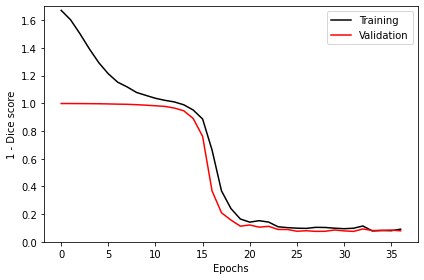

In [22]:
# Load a model
f = pd.read_csv(f"{model_loc}/training_log.csv")
plt.plot(f["epoch"], f["train_loss"], c = 'k')
plt.plot(f["epoch"], f["valid_loss"], c = 'r')
plt.ylim([0.0, 1.7])
plt.xlabel("Epochs")
plt.ylabel("1 - Dice score")
plt.legend(["Training", "Validation"], loc = "best")
plt.tight_layout()

In [23]:
### Initialize a unet
model = ResNetUNet(
    n_class = 1, 
    color_dim = color_dim
).to(device)


### Load the weights from the training location
checkpoint = torch.load(
    os.path.join(model_loc, "best.pt"), #"/glade/work/schreck/repos/HOLO/holodec-ml/holodecml/reader/models/unet_double_compare/best.pt"
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

logger.info(f"There are {total_params} total model parameters")

INFO:holodecml.propagation:There are 18313833 total model parameters


In [24]:
inference_transforms = LoadTransformations(conf["transforms"]["inference"])

INFO:holodecml.transforms:Loaded Normalize transformation that normalizes data color channel by dividing by 255.0 and phase pi


In [25]:
prop = InferencePropagator(
    data_set, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    device = device,
    model = model,
    mode = inference_mode,
    transforms = inference_transforms
)

In [26]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

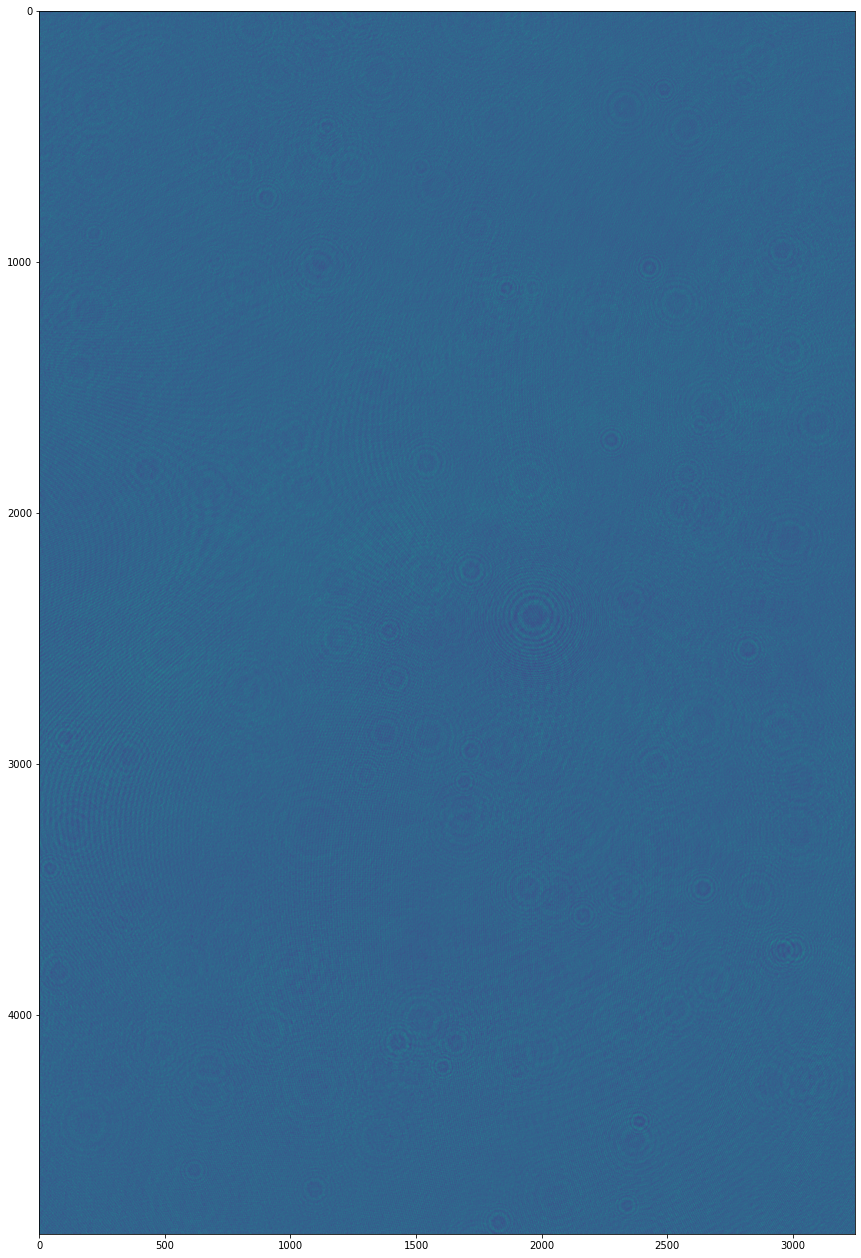

In [27]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (15, 15 * ratio))
plt.imshow(test_image.values)

In [34]:
total_holograms = len(np.unique(prop.h_ds["hid"].values))
total_holograms
#len(np.unique(prop.h_ds.isel(hologram_number=h_idx)["x"].values))

559

### Create a list of z-values to propagate to

In [35]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

### Set up thresholds to use for computing ROC

In [36]:
obs_threshold = 1.0

if conf["inference"]["data_set"]["name"] == "raw":
    thresholds = np.linspace(0, 1, 100)
else:
    thresholds = 1.0 - np.logspace(-5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
    thresholds = thresholds[::-1]

### Initialize the generator

In [37]:
inference_generator = prop.get_next_z_planes_labeled(
    h_idx, 
    z_list, 
    batch_size = batch_size, 
    thresholds = thresholds,
    obs_threshold = obs_threshold
)

### Main loop to call the generator, predict with the model, and aggregate and save the results

In [38]:
model.eval()
with torch.no_grad():

    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list),
        leave=True
    )

    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    holo_acc = []
    
    unet_particles = 0
    holo_particles = 0
    for z_idx, results_dict in jiter:

#         # Get stuff from the results dictionary
#         pred_label = results_dict["pred_output"]
#         pred_prob = results_dict["pred_proba"]

        z_plane = int(results_dict["z_plane"])
        true_label = results_dict["true_output"]
        save_sparse_csr(f"{prop_data_loc}/true_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))
        
#         z_plane = int(results_dict["z_plane"])

#         if save_arrays:
#             # Save the giant matrices as sparse arrays, as most elements are zero
#             save_sparse_csr(f"{prop_data_loc}/prob_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_prob))
#             save_sparse_csr(f"{prop_data_loc}/pred_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_label))
#             save_sparse_csr(f"{prop_data_loc}/true_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))

#         # Merge the ROC result 
#         this_roc = results_dict["roc"]
#         roc.merge(this_roc)
        
#         # Print some stuff
#         #plane = this_roc.binary_metrics()
#         #hologram = roc.binary_metrics()
#         plane_acc = (pred_label == true_label).mean()
#         holo_acc.append(plane_acc)
        
#         unet_plane_particles = np.sum(pred_label == 1)
#         holo_plane_particles = np.sum(true_label == 1)
#         unet_particles += unet_plane_particles
#         holo_particles += holo_plane_particles
        
#         to_print = f"Plane: {z_idx} at z: {z_plane*1e-6}"
#         to_print += f" plane_acc: {plane_acc:.4f}"
#         to_print += f" holo_acc: {np.mean(holo_acc):.4f}"
#         to_print += f" plane_csi: {this_roc.max_csi():.4f}"
#         to_print += f" holo_csi: {roc.max_csi():.4f}"
#         to_print += f" plane_(unet/suite): {int(unet_plane_particles)} / {int(holo_plane_particles)}"
#         to_print += f" holo_(unet/suite): {int(unet_particles)} / {int(holo_particles)}"
#         jiter.set_description(to_print)
#         jiter.update()
        
#         with open(f"{roc_data_loc}/roc_{h_idx}_{z_plane}.pkl", "wb") as fid:
#             joblib.dump(results_dict["roc"], fid)

#         # Option to plot each result per plane
#         if plot:
#             fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
#             p1 = ax0.imshow(pred_prob, vmin = 0,  vmax = 1)
#             ax0.set_title("In-focus confidence")
#             fig.colorbar(p1, ax=ax0)

#             p2 = ax1.imshow(pred_label, vmin = 0,  vmax = 1)
#             ax1.set_title("Predicted particles")
#             fig.colorbar(p2, ax=ax1)

#             p3 = ax2.imshow(true_label, vmin = 0, vmax = 1)
#             ax2.set_title("True particles")
#             fig.colorbar(p3, ax=ax2)

#             plt.tight_layout()
#             plt.show()

100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


In [62]:
roc_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_baseline/roc"
prop_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_baseline/propagated"
image_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_baseline/images"

# roc_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/noisy/roc"
# prop_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/noisy/propagated"
# image_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/noisy/images"

In [45]:
rocs = sorted(glob.glob(f"{roc_data_loc}/roc_{h_idx}_*.pkl"), 
                  key = lambda x: int(x.strip(".pkl").split("_")[-1]))
    
for k, roc_fn in enumerate(rocs):
    with open(roc_fn, "rb") as fid:
        if k == 0:
            roc = joblib.load(fid)
        else:
            roc.merge(joblib.load(fid))

with open(f"{roc_data_loc}/roc_{h_idx}.pkl", "wb") as fid:
    joblib.dump(roc, fid)

roc_curve([roc], [model_name], ["orange"], ["o"], f"{image_data_loc}/roc_comparison_{h_idx}.png")
performance_diagram([roc], [model_name], ["orange"], ["o"], f"{image_data_loc}/performance_comparison_{h_idx}.png")

In [63]:
true_examples = sorted(glob.glob(f"{prop_data_loc}/true_*_*.npz"), key = lambda x: int(x.split("_")[-1].strip(".npz")))
pred_examples = sorted(glob.glob(f"{prop_data_loc}/pred_*_*.npz"), key = lambda x: int(x.split("_")[-1].strip(".npz")))

In [3]:
def load_coordinates(examples):
    x, y, z = [], [], []
    total_particles = 0
    for example in tqdm.tqdm(examples):
        z_idx = int(example.split("_")[-1].strip(".npz"))
        loaded_array = load_sparse_csr(example.strip(".npz"))
        a = loaded_array.todok()
        if len(a) > 0:
            ix, iy = zip(*a.keys())
            x += list(ix)
            y += list(iy)
            z += [z_idx for xx in ix]
            total_particles += 1
    print(total_particles)
    return x, y, z

In [65]:
xt, yt, zt = load_coordinates(true_examples)

100%|██████████| 1000/1000 [00:01<00:00, 697.41it/s]

203


In [66]:
xp, yp, zp = load_coordinates(pred_examples)

100%|██████████| 995/995 [00:01<00:00, 562.25it/s]

190


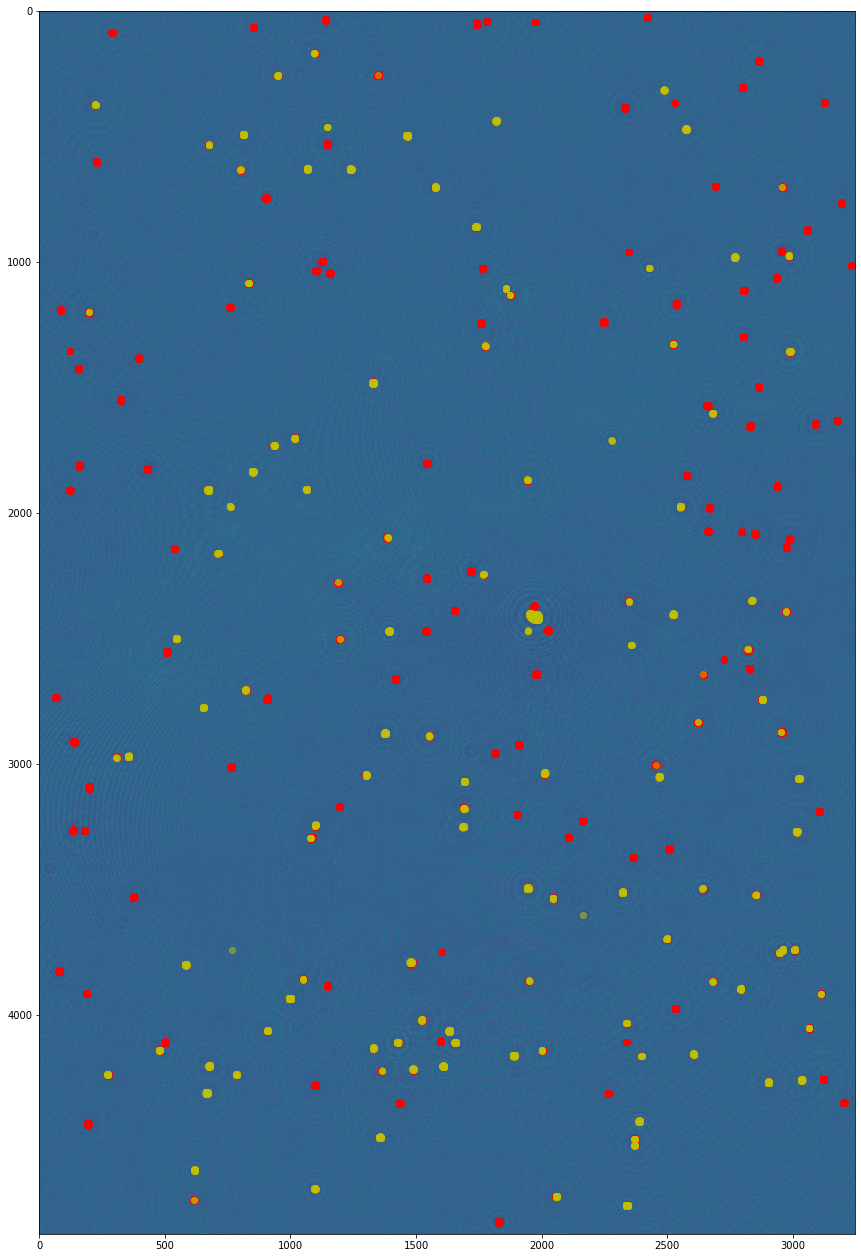

In [67]:
plt.figure(figsize = (15, 15 * ratio))
plt.imshow(test_image.values)
plt.scatter(yt, xt, c = "r", alpha = 0.5)
plt.scatter(yp, xp, c = "y", alpha = 0.5)

In [30]:
roc_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/real/roc"
prop_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/real/propagated"
image_data_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/unet_noisy/real/images"

In [31]:
h_idx = 10

In [32]:
true_examples = sorted(glob.glob(f"{prop_data_loc}/true_{h_idx}_*.npz"), key = lambda x: int(x.split("_")[-1].strip(".npz")))
pred_examples = sorted(glob.glob(f"{prop_data_loc}/pred_{h_idx}_*.npz"), key = lambda x: int(x.split("_")[-1].strip(".npz")))

In [33]:
xt, yt, zt = load_coordinates(true_examples)
xp, yp, zp = load_coordinates(pred_examples)

  6%|▋         | 64/1000 [00:00<00:01, 633.07it/s]

203


100%|██████████| 1000/1000 [00:03<00:00, 326.82it/s]

275


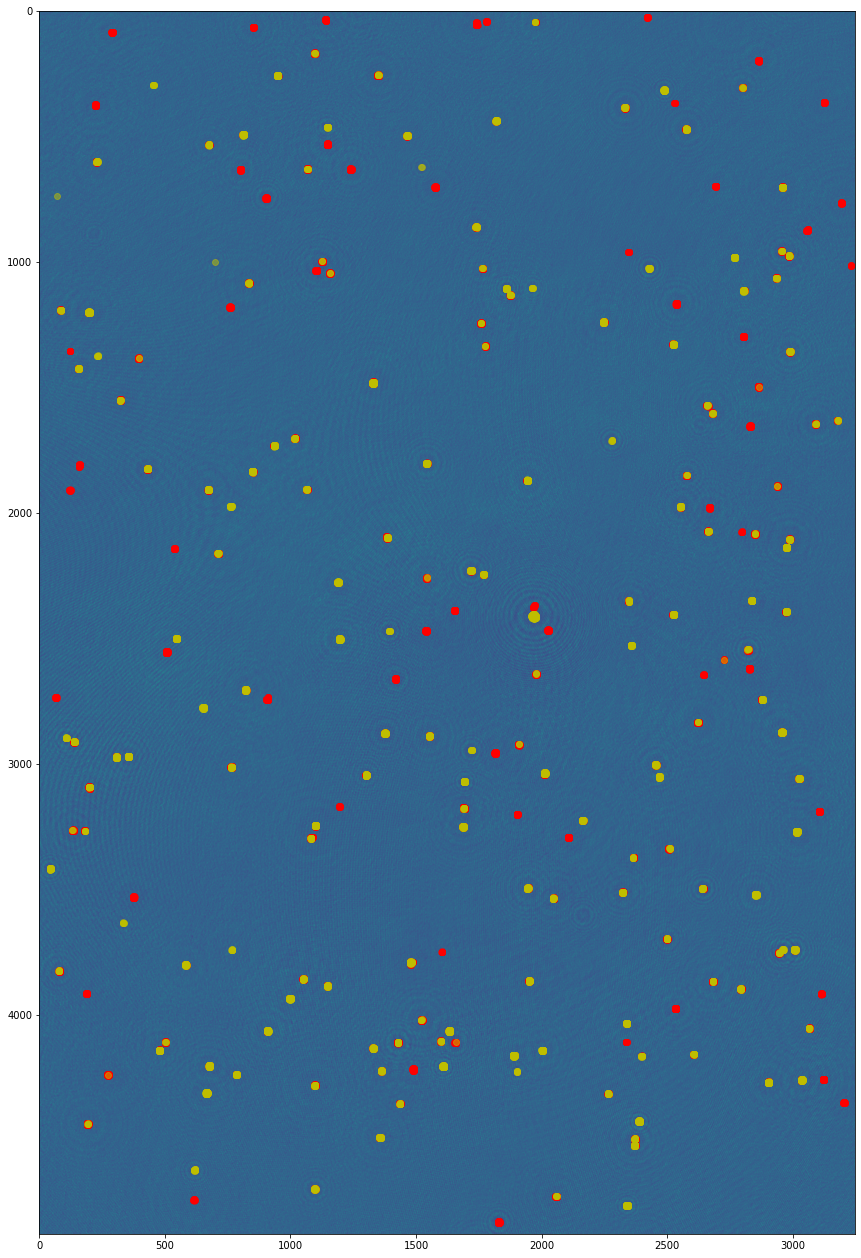

In [34]:
plt.figure(figsize = (15, 15 * 1.5))
plt.imshow(test_image.values)
plt.scatter(yt, xt, c = "r", alpha = 0.5)
plt.scatter(yp, xp, c = "y", alpha = 0.5)

In [28]:
ratio

1.5

In [86]:
# plt.figure(figsize = (15, 15 * ratio))
# plt.imshow(test_image.values)
# plt.scatter(yt, xt, c = "r", alpha = 0.5)
# plt.scatter(yp, xp, c = "y", alpha = 0.5)

In [126]:
# # locate particle information corresponding to this hologram
# particle_idx = np.where(prop.h_ds['hid'].values==h_idx+1)

# x_part = prop.h_ds['x'].values[particle_idx]
# y_part = prop.h_ds['y'].values[particle_idx]
# z_part = prop.h_ds['z'].values[particle_idx]
# d_part = prop.h_ds['d'].values[particle_idx]  # not used but here it is

# # create a 3D histogram 
# in_data = np.stack((x_part, y_part, z_part)).T
# h_part = np.histogramdd(in_data, bins=[prop.tile_x_bins,prop.tile_y_bins,prop.z_bins])[0]
# z_part_bin_idx = np.digitize(z_part, prop.z_bins)-1 # specify the z bin locations of the particles

# # smoothing kernel accounts for overlapping subimages when the 
# # subimage is larger than the stride
# if prop.step_size < prop.tile_size:
#     overlap_kernel = np.ones((
#         prop.tile_size//prop.step_size,prop.tile_size//prop.step_size
#     ))
#     for z_idx in range(h_part.shape[-1]):
#         b = prop.tile_size//prop.step_size
#         h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[b-1:h_part.shape[0]+b-1,b-1:h_part.shape[1]+b-1]

# input_image = prop.h_ds['image'].isel(hologram_number=h_idx).values

In [127]:
# for part_idx, actual_z_idx in enumerate(z_part_bin_idx):
#     a = (prop.y_arr[None,:]*1e6-y_part[part_idx])**2 + (prop.x_arr[:,None]*1e6-x_part[part_idx])**2  < (d_part[part_idx]/2)**2
#     if part_idx == 0:
#         unet_mask = a
#     else:
#         unet_mask += a
# xt, yt = np.where(unet_mask == 1)

In [61]:
# plt.figure(figsize = (15, 15 * ratio))
# plt.imshow(test_image.values)
# plt.scatter(yt, xt, c = "r", alpha = 0.5)
# plt.scatter(yp, xp, c = "y", alpha = 0.5)